In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# from google.colab import files
import numpy as np
import tarfile
import shutil
import json
import math
import cv2
import os

In [2]:
def select_white_yellow(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

In [3]:
def Get_Lane_Area(image, vertices):
  mask = np.zeros_like(image)

  if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
  else:
        ignore_mask_color = 255

  cv2.fillPoly(mask, vertices, ignore_mask_color)
  masked_image = cv2.bitwise_and(image, mask)

  return masked_image, mask

In [4]:
def Draw_Lines(image, lines, color=[255, 0, 0], thickness=12):
  for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(image, (x1, y1), (x2, y2), color, thickness)

In [5]:
def Hough_Transformation(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    Draw_Lines(line_image, lines, thickness=2)

    return line_image, lines

In [6]:
def Merge_Image(line_image, initial_image):
  # Check if images are None
  if line_image is None or initial_image is None:
      raise ValueError("One or both input images are None.")

  # Check if images have the same dimensions
  if line_image.shape != initial_image.shape:
      print(line_image.shape)
      print(initial_image.shape)

  # Check if images have the same data type
  if line_image.dtype != initial_image.dtype:
      raise ValueError("Input images must have the same data type.")
  return cv2.addWeighted(initial_image, 1.0, line_image, 1.0, 0.0)

In [7]:
def Plot_Image(image, title, subplot_pos):
    plt.subplot(*subplot_pos)
    plt.title(title)
    if len(image.shape) == 3:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap='gray')

In [8]:
def make_line_points(y1, y2, line):

    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return [x1, y1, x2, y2]# ((x1, y1), (x2, y2))

In [9]:
def connect_lane_lines(lines, imshape):
    try:
        left_lines    = [] # (slope, intercept)
        left_weights  = [] # (length,)
        right_lines   = [] # (slope, intercept)
        right_weights = [] # (length,)
        
        for line in lines:
            for x1, y1, x2, y2 in line:
                if x2==x1:
                    continue # ignore a vertical line
                slope = (y2-y1)/(x2-x1)
                intercept = y1 - slope*x1
                length = np.sqrt((y2-y1)**2+(x2-x1)**2)
                if slope < 0: # y is reversed in image
                    left_lines.append((slope, intercept))
                    left_weights.append((length))
                else:
                    right_lines.append((slope, intercept))
                    right_weights.append((length))
        
        # add more weight to longer lines    
        left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
        right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
        
        y1 = imshape[0] # bottom of the image
        y2 = y1*0.6         # slightly lower than the middle

        left_line  = make_line_points(y1, y2, left_lane)
        right_line = make_line_points(y1, y2, right_lane)
        
        connected_lines = np.int32([[left_line, right_line]])
        
        return connected_lines # left_line, right_line
    except Exception as e:
        print(e)

In [10]:
def draw_connected_lane_lines(img, connected_lines):
    # Get a copy of the original image
    lines_img = np.copy(img)*0
    Draw_Lines(lines_img, connected_lines, thickness=12)
    
    # vertices = []
    # l_line, r_line = connected_lines[0][0], connected_lines[0][1]

    # vertices.append((l_line[0], l_line[1]))
    # vertices.append((l_line[2], l_line[3]))
    # vertices.append((r_line[2], l_line[3]))
    # vertices.append((r_line[0], r_line[1]))
    
    # cv2.fillPoly(lines_img, np.int32([vertices]), [0,255,0])
    
    # Perform image blending
    return Merge_Image(lines_img, img)

In [11]:
def perform_smoothing(lines_history, win_size=10):
    l,r = [0,0,0,0], [0,0,0,0]
    lines_history = np.squeeze(lines_history)  
    for idx, line in enumerate(reversed(lines_history)):
        if idx == win_size:
            break
        l += line[0]
        r += line[1]
    
    return np.int32([[l/win_size, r/win_size]])

In [12]:
def Detect_Lane(image, plot_image=False,
                kernel_size=15, canny_low_threshold=50, canny_high_threshold=150,
                hough_rho=1, hough_theta=np.pi/180, hough_threshold=20,
                hough_min_line_len=20, hough_max_line_gap=300):
    
    # filter to select those white and yellow lines
    white_yellow_image = select_white_yellow(image)
    
    # Convert to gray scale
    gray = cv2.cvtColor(white_yellow_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    gray_blur = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Canny Edge Detection
    edges = cv2.Canny(gray_blur, canny_low_threshold, canny_high_threshold)

    # Concentrate the location of edge detection
    image_shape = image.shape

    print(image_shape[0], image_shape[1])
    vertices = np.array([[(100,image_shape[0]),
                          (image_shape[1]/2-30, image_shape[0]/2+50),
                          (image_shape[1]/2+30, image_shape[0]/2+50),
                          (image_shape[1]-20, image_shape[0])]], dtype=np.int32)

    masked_edges, mask = Get_Lane_Area(edges, vertices=vertices)

    # Detect lines using Hough transform on an edge detected image
    lines_image, lines = Hough_Transformation(masked_edges,
                                  rho=hough_rho, theta=hough_theta, threshold=hough_threshold,
                                  min_line_len=hough_min_line_len, max_line_gap=hough_max_line_gap)

    # Merge 'original' image with 'lines' image
    result = Merge_Image(lines_image, image)
    connected_lines = connect_lane_lines(lines, image_shape)
    
    # Plot the images
    if plot_image:
        plt.figure(figsize=[16, 9])
        for i, img in enumerate(['white_yellow_image', 'gray', 'gray_blur', 'edges', 'mask', 'masked_edges', 'lines_image', 'result']):
            Plot_Image(eval(img), img, (4,2, i+1))
            plt.axis('off')
            plt.show()
    return result, connected_lines, white_yellow_image, gray, gray_blur, edges, masked_edges, lines_image # lines

In [13]:
def process_image(image):
    
    # Find the lanes
    result, connected_lines, white_yellow_image, gray, gray_blur, edges, mask, lines_image = Detect_Lane(image, plot_image=False,
                                    kernel_size=15, canny_low_threshold=50, canny_high_threshold=150,
                                    hough_rho=1, hough_theta=np.pi/180, hough_threshold=20,
                                    hough_min_line_len=20, hough_max_line_gap=300)
    # print(connected_lines)
    try:
        result1 = draw_connected_lane_lines(image, connected_lines)
    except Exception as e:
        for i, img in enumerate(['image', 'white_yellow_image', 'gray', 'gray_blur', 'edges', 'mask', 'lines_image']):
            Plot_Image(eval(img), img, (4,2, i+1))
            plt.axis('off')
            plt.show()
        return connected_lines, result
            
    return connected_lines, result1

In [14]:
# only run on google colab

# uploaded = files.upload()

# for filename in uploaded.keys():
#   shutil.move(filename, os.path.join(test_video_path, filename))

In [15]:
width = 1640
height = 590
def ReadFile(folder):
    DuLieu = []
    Label = []
    label = ''
    for file_path in os.listdir(folder):
        file_path = os.path.join(folder, file_path)
        list_filename_path = []
        label = file_path
        print(file_path)
        for filename in os.listdir(file_path):
            if (".jpg" in filename or ".png" in filename):
                filename_path = os.path.join(file_path, filename)
                img = numpy.array(Image.open(filename_path))
                img = cv2.resize(img, (width, height))
                list_filename_path.append(img)
                # Label.append(dict[(label)])
        DuLieu.extend(list_filename_path)
    return DuLieu, Label

In [16]:
import numpy
from PIL import Image

In [18]:
LANE = 'lane'
XTrain, YTrain = ReadFile(LANE)
# print(len(XTrain))
print(XTrain[0].shape)

lane\right
lane\wrong
(590, 1640, 3)


590 1640
setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.


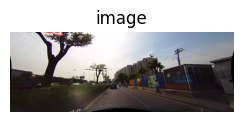

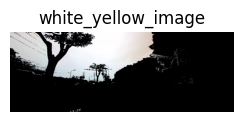

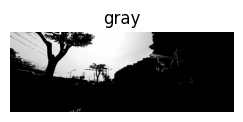

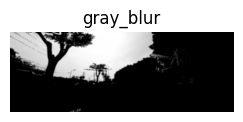

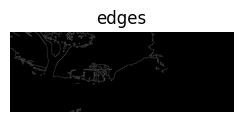

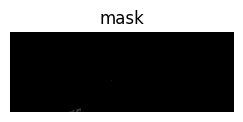

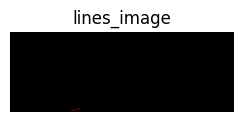

None
590 1640
[[[ 415  590 1416  354]
  [1149  590  674  354]]]
590 1640
setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.


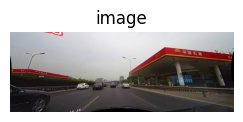

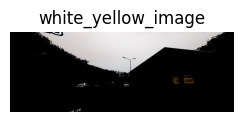

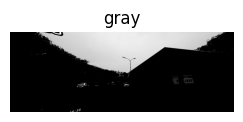

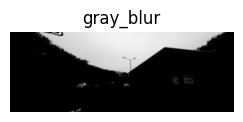

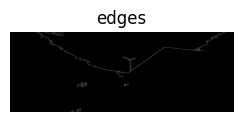

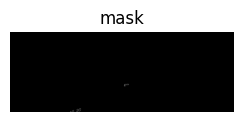

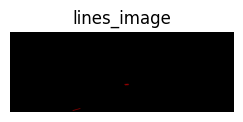

None
590 1640
setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.


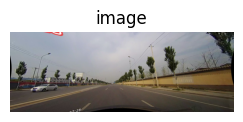

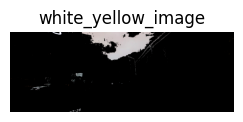

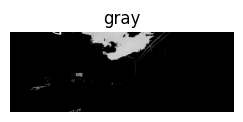

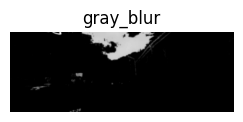

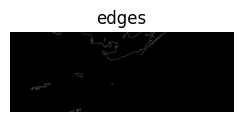

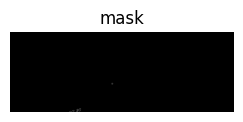

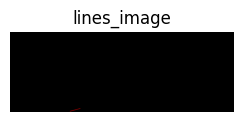

None
590 1640
setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.


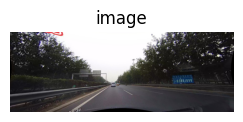

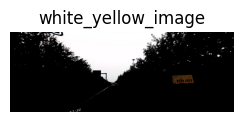

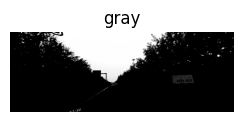

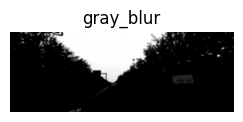

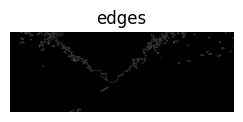

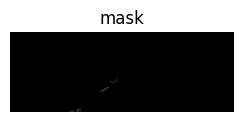

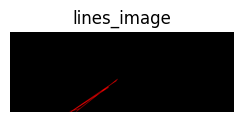

None
590 1640
[[[-375  590  955  354]
  [4899  590  190  354]]]
590 1640
setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.


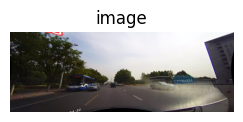

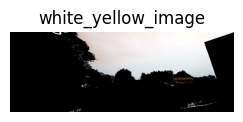

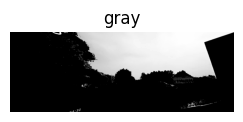

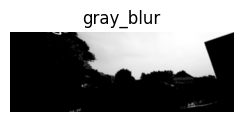

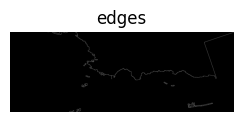

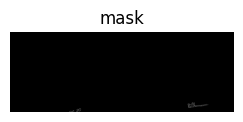

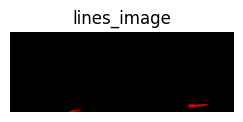

None
590 1640
[[[ 467  590  801  354]
  [1827  590  611  354]]]
590 1640
setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.


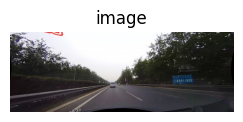

KeyboardInterrupt: 

In [19]:
count = 0
for i in XTrain:
    try:
        connected_lines, result = process_image(i)
        print(connected_lines)
    except Exception as e:
        print(e)
        continue
    count = count + 1
    
print(count)